In [1]:
!pip install --quiet yfinance xgboost scikit-learn pandas numpy matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/WQU TASK"


bq-results-20260110-163239-1768063038845.csv  TASK-1.ipynb
bq-results-20260110-172838-1768066131462.csv  TASK-2.ipynb
bq-results-20260110-173142-1768066341099.csv


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [7]:
events = pd.read_csv(
    "/content/drive/MyDrive/WQU TASK/bq-results-20260110-163239-1768063038845.csv"
)

mentions = pd.read_csv(
    "/content/drive/MyDrive/WQU TASK/bq-results-20260110-172838-1768066131462.csv"
)

gkg = pd.read_csv(
    "/content/drive/MyDrive/WQU TASK/bq-results-20260110-173142-1768066341099.csv"
)


In [8]:
print(events.head())
print(mentions.head())
print(gkg.head())

         date  total_events  avg_goldstein  protest_events  conflict_events  \
0  2015-01-01           225       1.056889               4               16   
1  2015-01-02           225       0.585333               6               24   
2  2015-01-03           225       0.460444               4               25   
3  2015-01-04           479       0.000209              15               56   
4  2015-01-05           659      -0.885736              23              117   

   govt_events  
0           18  
1           33  
2           19  
3           71  
4           66  
         date  total_mentions  avg_tone
0  2015-02-17              25 -2.911320
1  2015-02-18           96491 -2.849287
2  2015-02-19          929902 -2.498021
3  2015-02-20          893032 -2.585716
4  2015-02-21          658329 -2.829145
         date  total_articles  avg_tone
0  2015-02-17              25 -0.432493
1  2015-02-18           55409 -1.102221
2  2015-02-19          551962 -1.058308
3  2015-02-20          

/tmp/ipython-input-737805453.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download(


Directional Accuracy = 52.4891%
Total observations = 2290
              precision    recall  f1-score   support

           0       0.46      0.32      0.38      1028
           1       0.56      0.69      0.62      1262

    accuracy                           0.52      2290
   macro avg       0.51      0.51      0.50      2290
weighted avg       0.51      0.52      0.51      2290



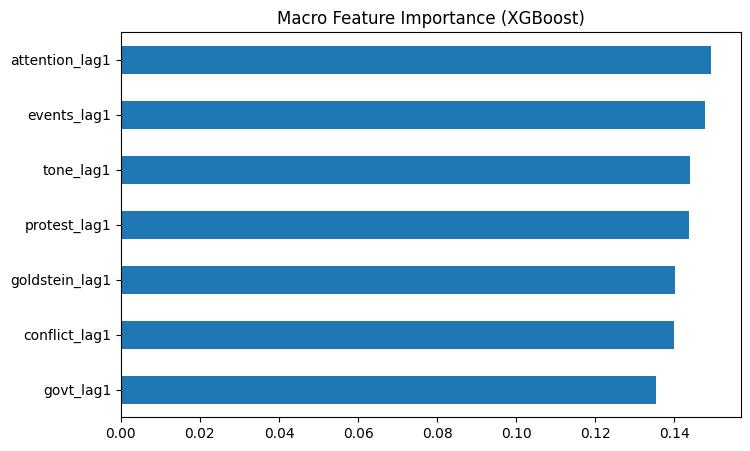

High-confidence macro signal days: 102


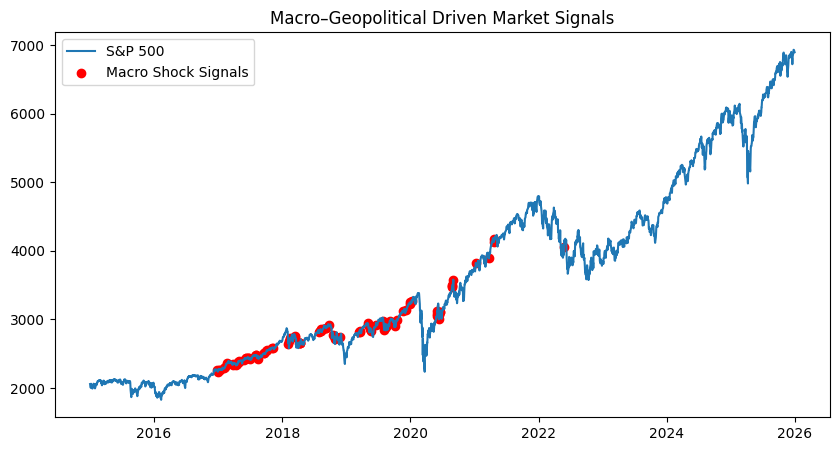

In [14]:
for df in [events, mentions, gkg]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date


macro = events.merge(mentions, on="date", how="outer", suffixes=("", "_mentions"))
macro = macro.merge(gkg, on="date", how="outer", suffixes=("", "_gkg"))
macro.sort_values("date", inplace=True)
macro.reset_index(drop=True, inplace=True)

tone_candidates = [c for c in macro.columns if "avg_tone" in c.lower()]

if len(tone_candidates) == 0:
    macro["avg_tone"] = 0.0
elif len(tone_candidates) == 1:
    macro["avg_tone"] = pd.to_numeric(macro[tone_candidates[0]], errors="coerce")
else:
    macro["avg_tone"] = (
        macro[tone_candidates]
        .apply(pd.to_numeric, errors="coerce")
        .mean(axis=1)
    )

numeric_cols = [
    "total_events", "avg_goldstein",
    "protest_events", "conflict_events", "govt_events",
    "total_mentions", "total_articles", "avg_tone"
]

for col in numeric_cols:
    if col not in macro.columns:
        macro[col] = 0.0
    macro[col] = pd.to_numeric(macro[col], errors="coerce")

macro.fillna(0, inplace=True)

sp = yf.download(
    "^GSPC",
    start=str(macro["date"].min()),
    end=str(macro["date"].max()),
    progress=False
)

sp.columns = sp.columns.get_level_values(0)
sp = sp.reset_index()
sp["date"] = pd.to_datetime(sp["Date"]).dt.date
sp["return"] = sp["Close"].pct_change()
sp["direction"] = (sp["return"] > 0).astype(int)

data = macro.merge(
    sp[["date", "return", "direction"]],
    on="date",
    how="inner"
)

data.sort_values("date", inplace=True)
data.reset_index(drop=True, inplace=True)

lag_map = {
    "avg_goldstein": "goldstein_lag1",
    "avg_tone": "tone_lag1",
    "total_events": "events_lag1",
    "conflict_events": "conflict_lag1",
    "protest_events": "protest_lag1",
    "govt_events": "govt_lag1",
    "total_mentions": "attention_lag1"
}

for src, tgt in lag_map.items():
    data[tgt] = data[src].shift(1)

data.dropna(inplace=True)

features = list(lag_map.values())
X = data[features]
y = data["direction"]

tscv = TimeSeriesSplit(n_splits=5)

preds, truth = [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    preds.extend(y_pred.tolist())
    truth.extend(y_test.tolist())

accuracy = accuracy_score(truth, preds) * 100
print(f"Directional Accuracy = {accuracy:.4f}%")
print(f"Total observations = {len(truth)}")
print(classification_report(truth, preds))

importance = pd.Series(
    model.feature_importances_,
    index=features
).sort_values()

importance.plot(kind="barh", figsize=(8,5))
plt.title("Macro Feature Importance (XGBoost)")
plt.show()

data["predicted_direction"] = np.nan
data.loc[data.index[-len(preds):], "predicted_direction"] = preds

signal_days = data[
    (data["predicted_direction"] == 1) &
    (data["tone_lag1"] < data["tone_lag1"].quantile(0.3)) &
    (data["conflict_lag1"] > data["conflict_lag1"].quantile(0.7))
]

print("High-confidence macro signal days:", len(signal_days))

plt.figure(figsize=(10,5))
plt.plot(sp["date"], sp["Close"], label="S&P 500")
plt.scatter(
    signal_days["date"],
    sp.set_index("date").loc[signal_days["date"], "Close"],
    color="red",
    label="Macro Shock Signals"
)
plt.legend()
plt.title("Macro–Geopolitical Driven Market Signals")
plt.show()


/tmp/ipython-input-3135080790.py:63: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp = yf.download(
[*********************100%***********************]  1 of 1 completed


MAE (Volatility): 0.004849
R² Score: -0.1140
Total observations = 2290


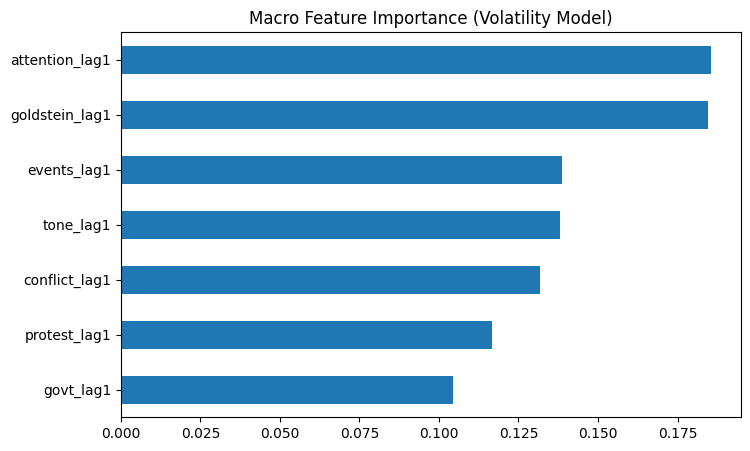

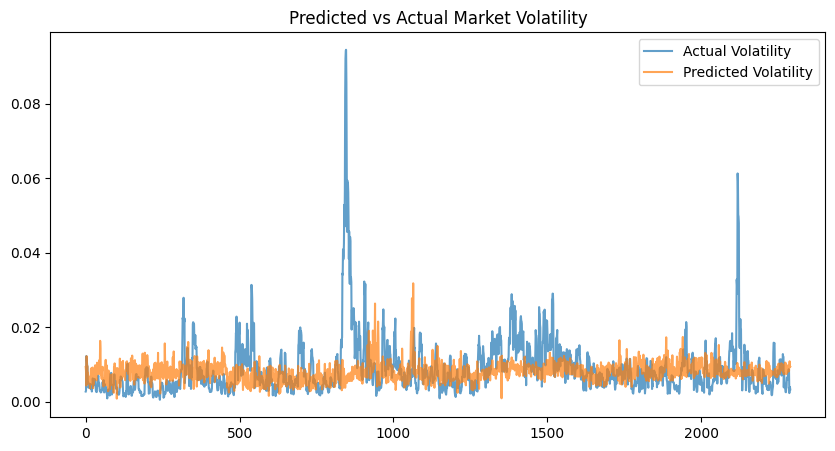

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

# -------------------------------
# 1. DATE ALIGNMENT
# -------------------------------
for df in [events, mentions, gkg]:
    df["date"] = pd.to_datetime(df["date"]).dt.date

# -------------------------------
# 2. MERGE MACRO DATA
# -------------------------------
macro = events.merge(mentions, on="date", how="outer")
macro = macro.merge(gkg, on="date", how="outer")
macro.sort_values("date", inplace=True)

# -------------------------------
# NUMERIC SAFETY
# -------------------------------
numeric_cols = [
    "total_events", "avg_goldstein",
    "protest_events", "conflict_events", "govt_events",
    "total_mentions", "total_articles"
]

for col in numeric_cols:
    if col in macro.columns:
        macro[col] = pd.to_numeric(macro[col], errors="coerce")

# -------------------------------
# FIX avg_tone COLLISION (CRITICAL)
# -------------------------------
tone_cols = [c for c in macro.columns if "avg_tone" in c.lower()]

if len(tone_cols) == 1:
    macro["avg_tone"] = pd.to_numeric(macro[tone_cols[0]], errors="coerce")

elif len(tone_cols) >= 2:
    macro["avg_tone"] = (
        macro[tone_cols]
        .apply(pd.to_numeric, errors="coerce")
        .mean(axis=1)
    )

else:
    raise ValueError("No tone column found in mentions or GKG")

# Drop old tone columns safely
macro.drop(columns=tone_cols, inplace=True, errors="ignore")

macro.fillna(0, inplace=True)


# -------------------------------
# 4. LOAD S&P 500
# -------------------------------
sp = yf.download(
    "^GSPC",
    start=str(macro["date"].min()),
    end=str(macro["date"].max())
)

sp.columns = sp.columns.get_level_values(0)
sp = sp.reset_index()
sp["date"] = sp["Date"].dt.date

# Daily returns
sp["return"] = sp["Close"].pct_change()

# 🎯 TARGET: 5-day forward volatility
sp["future_volatility"] = (
    sp["return"]
    .rolling(5)
    .std()
    .shift(-5)
)

# -------------------------------
# 5. MERGE MARKET + MACRO
# -------------------------------
data = macro.merge(
    sp[["date", "future_volatility"]],
    on="date",
    how="inner"
)

data.sort_values("date", inplace=True)

# -------------------------------
# 6. LAG MACRO FEATURES (NO LEAKAGE)
# -------------------------------
data["goldstein_lag1"] = data["avg_goldstein"].shift(1)
data["tone_lag1"] = data["avg_tone"].shift(1)
data["events_lag1"] = data["total_events"].shift(1)
data["conflict_lag1"] = data["conflict_events"].shift(1)
data["protest_lag1"] = data["protest_events"].shift(1)
data["govt_lag1"] = data["govt_events"].shift(1)
data["attention_lag1"] = data["total_mentions"].shift(1)

data.dropna(inplace=True)

# -------------------------------
# 7. FEATURES & TARGET
# -------------------------------
features = [
    "goldstein_lag1",
    "tone_lag1",
    "events_lag1",
    "conflict_lag1",
    "protest_lag1",
    "govt_lag1",
    "attention_lag1"
]

X = data[features]
y = data["future_volatility"]

# -------------------------------
# 8. TIME-SERIES REGRESSION
# -------------------------------
tscv = TimeSeriesSplit(n_splits=5)

preds, truth = [], []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    preds.extend(y_pred)
    truth.extend(y_test)

# -------------------------------
# 9. METRICS
# -------------------------------
mae = mean_absolute_error(truth, preds)
r2 = r2_score(truth, preds)

print(f"MAE (Volatility): {mae:.6f}")
print(f"R² Score: {r2:.4f}")
print(f"Total observations = {len(truth)}")

# -------------------------------
# 10. FEATURE IMPORTANCE
# -------------------------------
importance = pd.Series(
    model.feature_importances_,
    index=features
).sort_values()

importance.plot(kind="barh", figsize=(8,5))
plt.title("Macro Feature Importance (Volatility Model)")
plt.show()


plt.figure(figsize=(10,5))
plt.plot(truth, label="Actual Volatility", alpha=0.7)
plt.plot(preds, label="Predicted Volatility", alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Market Volatility")
plt.show()
